<a href="https://colab.research.google.com/github/Rin4797/Data_Augmentation_Research/blob/main/drafts/MobileNet_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pickle

import tensorflow as tf

from sklearn.utils import shuffle

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import multilabel_confusion_matrix

# Формирование датасета

## Загрузка данных

In [3]:
!mkdir data
%cd data

/content/data


In [4]:
!wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvf 'cifar-10-python.tar.gz'
!rm cifar-10-python.tar.gz

--2023-08-06 08:26:40--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  28.9MB/s    in 6.2s    

2023-08-06 08:26:46 (26.1 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [5]:
%cd cifar-10-batches-py
!ls
%cd ..
%cd ..

/content/data/cifar-10-batches-py
batches.meta  data_batch_2  data_batch_4  readme.html
data_batch_1  data_batch_3  data_batch_5  test_batch
/content/data
/content


## Формирование данных

In [6]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [7]:
# список названия классов

cifar_label_data = unpickle('data/cifar-10-batches-py/batches.meta')
label_names = cifar_label_data[b'label_names']
for i in range(len(label_names)):
    label_names[i] = label_names[i].decode('ASCII')
label_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [29]:
def image_format(image_data):
    return (np.transpose(image_data.reshape(32, 32, 3, order='F'), axes=[1,0,2]))

In [8]:
def unpack_batch(batch_name):
    cifar_data = unpickle('data/cifar-10-batches-py/' + batch_name)
    data = cifar_data[b'data']
    labels = np.array(cifar_data[b'labels'])
    return data, labels

In [9]:
x_train = np.empty((0, 3072))
y_train = np.empty((0, ))
for i in range(5):
    data, labels = unpack_batch('data_batch_' + str(i + 1))
    x_train = np.concatenate((x_train, data), axis=0)
    y_train = np.concatenate((y_train, labels), axis=0)
print(x_train.shape, y_train.shape)

(50000, 3072) (50000,)


In [10]:
x_test, y_test = unpack_batch('test_batch')
print(x_test.shape, y_test.shape)

(10000, 3072) (10000,)


## Предобработка данных

In [11]:
x_train , y_train = shuffle(x_train, y_train)
x_test, y_test = shuffle(x_test, y_test)

In [12]:
val_size = 10000
x_val = x_train[-val_size:]
y_val = y_train[-val_size:]
x_train = x_train[:-val_size]
y_train = y_train[:-val_size]

In [13]:
# векторизация результатов

y_vect_train = tf.keras.utils.to_categorical(y_train)
y_vect_test = tf.keras.utils.to_categorical(y_test)
y_vect_val = tf.keras.utils.to_categorical(y_val)

In [31]:
# формирование изображений из входных данных

x_image_train = np.array([image_format(i) for i in x_train])
x_image_test = np.array([image_format(i) for i in x_test])
x_image_val = np.array([image_format(i) for i in x_val])

## Описание датасета

In [14]:
def data_analysis(labels):
    unique, counts = np.unique(labels, return_counts=True)
    unique_names = ['' for i in range(len(unique))]
    for i in range(len(unique)):
        unique_names[i] = label_names[np.int64(unique[i])]
    return dict(zip(unique_names, counts))

In [15]:
batch_analysis = pd.DataFrame(columns = label_names)
rows = []
rows.append(data_analysis(y_train))
rows.append(data_analysis(y_val))
rows.append(data_analysis(y_test))
batches_analysis = pd.DataFrame()
batches_analysis['name'] = ['train', 'val', 'test']
batches_analysis['size'] = [y_train.shape[0],y_val.shape[0], y_test.shape[0] ]
batches_analysis = batches_analysis.join(pd.DataFrame.from_dict(rows, orient='columns'))
# batches_analysis['average'] = np.average(batches_analysis[label_names], axis=1)
batches_analysis['std'] = np.std(batches_analysis[label_names], axis=1)

In [16]:
batches_analysis[['name', 'size', 'std']]

,name,size,std
0,train,40000,27.978563
1,val,10000,27.978563
2,test,10000,0.000000


In [17]:
batches_analysis[['name'] + label_names]

,name,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,train,4025,3943,4008,4037,3967,4022,3992,4016,4012,3978
1,val,975,1057,992,963,1033,978,1008,984,988,1022
2,test,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000


# Создание нейростети MobileNet

In [61]:
model1 = tf.keras.applications.MobileNet(
    input_shape=(32, 32, 3), #image_size
    alpha=1.0,
    depth_multiplier=1,
    dropout=0.001,
    include_top=True,
    weights=None,
    input_tensor=None,
    pooling=None,
    classes=10, #cifar-10
    classifier_activation="softmax"
)

In [62]:
model1.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [63]:
model1.summary()

Model: "mobilenet_1.00_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 16, 16, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 16, 16, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 16, 16, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 16, 16, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 16, 16, 32)       128       
 ation)                                          

# Обучение нейросети

In [66]:
history = model1.fit(x_image_train, y_vect_train, batch_size = 64, epochs = 20, validation_data = (x_image_val, y_vect_val))

Epoch 1/20
625/625 [==============================] - 449s 719ms/step - loss: 1.6378 - accuracy: 0.4012 - val_loss: 2.5182 - val_accuracy: 0.3678
Epoch 2/20
625/625 [==============================] - 425s 680ms/step - loss: 1.4653 - accuracy: 0.4701 - val_loss: 1.5946 - val_accuracy: 0.4515
Epoch 3/20
625/625 [==============================] - 430s 689ms/step - loss: 1.3684 - accuracy: 0.5112 - val_loss: 1.4417 - val_accuracy: 0.4954
Epoch 4/20
625/625 [==============================] - 435s 696ms/step - loss: 1.2595 - accuracy: 0.5515 - val_loss: 1.6034 - val_accuracy: 0.4842
Epoch 5/20
625/625 [==============================] - 435s 696ms/step - loss: 1.1838 - accuracy: 0.5827 - val_loss: 1.4140 - val_accuracy: 0.5103
Epoch 6/20
625/625 [==============================] - 445s 712ms/step - loss: 1.1242 - accuracy: 0.6030 - val_loss: 1.3317 - val_accuracy: 0.5436
Epoch 7/20
625/625 [==============================] - 438s 701ms/step - loss: 1.0688 - accuracy: 0.6245 - val_loss: 1.3351 -

In [71]:
def draw_model_plot(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epoch_range = range(len(acc))

    plt.plot(epoch_range, acc, label='Training accuracy')
    plt.plot(epoch_range, val_acc, label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epoch_range, loss, label='Training loss')
    plt.plot(epoch_range, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

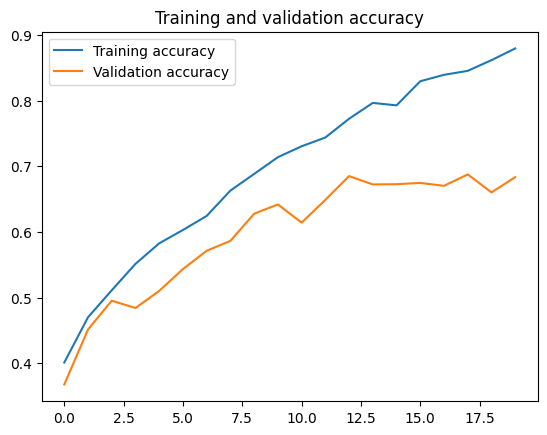

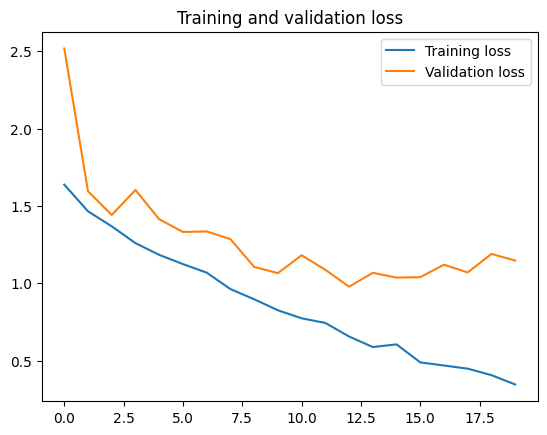

In [72]:
draw_model_plot(history)

In [73]:
loss, accuracy = model1.evaluate(x_image_test,y_vect_test)
print("Accuracy for test data : ", accuracy)
print("Loss for test data : ", loss)

313/313 [==============================] - 11s 34ms/step - loss: 1.1456 - accuracy: 0.6878
Accuracy for test data :  0.6877999901771545
Loss for test data :  1.1455578804016113


# Результат обучения

## Confusion matrix

In [77]:
rounded_labels=np.argmax(y_vect_test, axis=1)

preds = model1.predict(x_image_test, batch_size = 64, verbose = 1)
preds = np.argmax(preds, axis=1) # to get the indices of max value in each row
cr = confusion_matrix(rounded_labels, preds)
print("The confusion Matrix: \n",cr)

157/157 [==============================] - 9s 58ms/step
The confusion Matrix: 
 [[826  16  13  36  18   3   5   4  58  21]
 [ 27 771   3  14   6  10   8   4  50 107]
 [161   3 499  84 112  39  59  17  22   4]
 [ 47   8  64 512  90 150  77  25  10  17]
 [ 42   4  50  57 704  26  57  49   8   3]
 [ 31   2  55 231  68 518  29  46  11   9]
 [ 21   2  34  64  58  21 776   3  20   1]
 [ 45   3  53  53 107  55  10 652   5  17]
 [ 79  21   8  25   2   7   3   6 827  22]
 [ 53  59  11  24   2  10   9  16  23 793]]


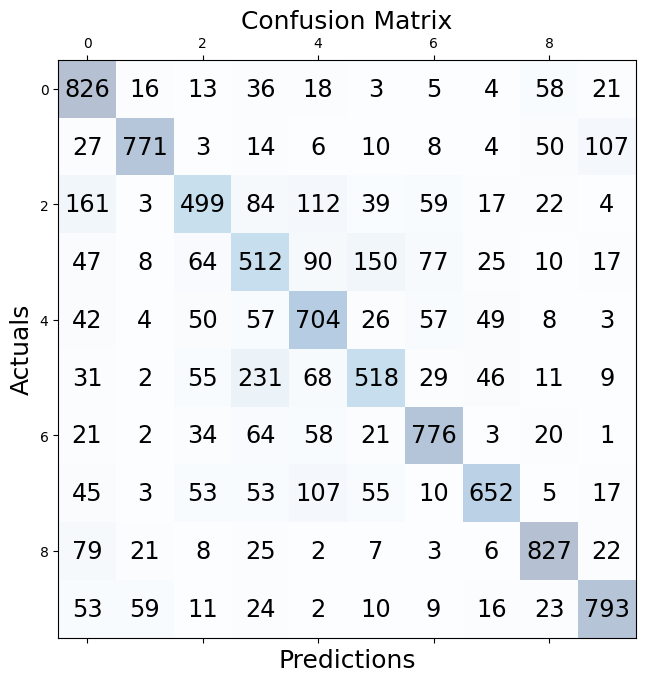

In [78]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cr, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cr.shape[0]):
    for j in range(cr.shape[1]):
        ax.text(x=j, y=i,s=cr[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

## Classification report

In [79]:
print(classification_report(rounded_labels, preds))

              precision    recall  f1-score   support

           0       0.62      0.83      0.71      1000
           1       0.87      0.77      0.82      1000
           2       0.63      0.50      0.56      1000
           3       0.47      0.51      0.49      1000
           4       0.60      0.70      0.65      1000
           5       0.62      0.52      0.56      1000
           6       0.75      0.78      0.76      1000
           7       0.79      0.65      0.72      1000
           8       0.80      0.83      0.81      1000
           9       0.80      0.79      0.80      1000

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.69     10000
weighted avg       0.69      0.69      0.69     10000



## Precision

In [83]:
acc={}
l=len(cr)
for i in range(0,l):
    acc[i]=cr[i][i]/sum(cr[:, i])
print("Precision: \n",acc)

Precision: 
 {0: 0.6201201201201201, 1: 0.8672665916760405, 2: 0.6316455696202532, 3: 0.46545454545454545, 4: 0.6032562125107113, 5: 0.6174016686531585, 6: 0.7512100677637947, 7: 0.7931873479318735, 8: 0.7998065764023211, 9: 0.7977867203219315}


## Recall

In [81]:
Recall ={}
for i in range(0,l):
     Recall[i]= cr[i][i]/sum(cr[i,:])
print("Recall: \n",Recall)

Recall: 
 {0: 0.826, 1: 0.771, 2: 0.499, 3: 0.512, 4: 0.704, 5: 0.518, 6: 0.776, 7: 0.652, 8: 0.827, 9: 0.793}


## F1-score

In [82]:
f1 ={}
for i in range(0,l):
     f1[i] = 2 * (cr[i,i] / sum(cr[:,i])) * (cr[i,i]/sum(cr[i,:])) / ((cr[i,i] / sum(cr[:,i])) + (cr[i,i]/sum(cr[i,:])))
print("F1- score: \n",f1)

F1- score: 
 {0: 0.7084048027444253, 1: 0.8163049232398094, 2: 0.5575418994413408, 3: 0.4876190476190476, 4: 0.649746192893401, 5: 0.5633496465470365, 6: 0.76340383669454, 7: 0.7156970362239298, 8: 0.8131760078662733, 9: 0.7953861584754263}
